## Compare filters

In [21]:
import sys
sys.path.append('/home/eay8226/gcm-filters')
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from gcm_filters import filter
from gcm_filters.kernels import GridType
from vorticity import compute_vorticity

In [22]:
import os
print(os.getcwd())

/home/arthur/python/NYU/gcm-filters/mom5_example


Script parameters

In [23]:
# region
lats = slice(-50, -30)
lons = slice(20, 40)
latsT = slice(-50, -29.9)
lonsT = slice(20, 40)

cmap='Spectral'
vmax=0.2
vmin=-vmax

plt_args = dict(vmin=vmin, vmax=vmax, cmap=cmap)

Read the data from North Atlantic


In [24]:
from read_data import read_data
data_location = '/media/arthur/DATA/Data sets/CM2.6'
grid_filename = 'grid_dataforeli'
uv_filename = 'uv_dataforeli'

grid_data, data = read_data(data_location, uv_filename, grid_filename)
grid_data = grid_data.compute().reset_coords()
data = data[['usurf', 'vsurf']].sel(xu_ocean=lons, yu_ocean=lats).isel(time=0)
data_saved = data
grid_data_save = grid_data

Question: how do we address continents?

Problem: we need the grid vars to be on the same grid as the field to
be filtered. Here I've interpolated, but I think this is not right,
we can probably just redefine the coords of dxt and dyt to be those of the
velocities, we'll just have to be careful.

In [25]:
grid_data = grid_data[['dxt', 'dyt', 'dxu', 'dyu', 'area_u']]
# Here we need dxt and dyt to be on the velocity grid
velocity_coords = grid_data[['yu_ocean', 'xu_ocean']]
grid_data['dxt'] = xr.DataArray(data=grid_data['dxt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data['dyt'] = xr.DataArray(data=grid_data['dyt'],
                                dims=('yu_ocean', 'xu_ocean'),
                                coords=velocity_coords)
grid_data = grid_data.sel(xu_ocean=lons, yu_ocean=lats)
del grid_data['xt_ocean']
del grid_data['yt_ocean']
print(grid_data)

<xarray.Dataset>
Dimensions:   (xu_ocean: 200, yu_ocean: 265)
Coordinates:
  * xu_ocean  (xu_ocean) float64 20.1 20.2 20.3 20.4 ... 39.7 39.8 39.9 40.0
  * yu_ocean  (yu_ocean) float64 -49.99 -49.93 -49.87 ... -30.2 -30.11 -30.02
Data variables:
    dxt       (yu_ocean, xu_ocean) float64 7.143e+03 7.143e+03 ... 9.623e+03
    dyt       (yu_ocean, xu_ocean) float64 7.143e+03 7.143e+03 ... 9.623e+03
    dxu       (yu_ocean, xu_ocean) float64 7.148e+03 7.148e+03 ... 9.627e+03
    dyu       (yu_ocean, xu_ocean) float64 7.148e+03 7.148e+03 ... 9.627e+03
    area_u    (yu_ocean, xu_ocean) float32 5.11e+07 5.11e+07 ... 9.269e+07
Attributes:
    NCO:      4.0.3


In [26]:
grid_dataT = grid_data_save[['dxt', 'dyt', 'dxu', 'dyu', 'area_t']]
tracer_coords = grid_dataT[['yt_ocean', 'xt_ocean']]

grid_dataT['dxu'] = xr.DataArray(data=grid_dataT['dxu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT['dyu'] = xr.DataArray(data=grid_dataT['dyu'],
                                dims=('yt_ocean', 'xt_ocean'),
                                coords=tracer_coords)
grid_dataT = grid_dataT.sel(xt_ocean=lonsT, yt_ocean=latsT)
del grid_dataT['xu_ocean']
del grid_dataT['yu_ocean']

print(grid_dataT)

<xarray.Dataset>
Dimensions:   (xt_ocean: 200, yt_ocean: 265)
Coordinates:
  * xt_ocean  (xt_ocean) float64 20.05 20.15 20.25 20.35 ... 39.75 39.85 39.95
  * yt_ocean  (yt_ocean) float64 -49.96 -49.9 -49.83 ... -30.15 -30.07 -29.98
Data variables:
    dxt       (yt_ocean, xt_ocean) float64 7.153e+03 7.153e+03 ... 9.632e+03
    dyt       (yt_ocean, xt_ocean) float64 7.153e+03 7.153e+03 ... 9.632e+03
    dxu       (yt_ocean, xt_ocean) float64 7.158e+03 7.158e+03 ... 9.636e+03
    dyu       (yt_ocean, xt_ocean) float64 7.158e+03 7.158e+03 ... 9.636e+03
    area_t    (yt_ocean, xt_ocean) float32 5.117e+07 5.117e+07 ... 9.277e+07
Attributes:
    NCO:      4.0.3


Create the filter and print its specs

In [27]:
dx_min = np.min(grid_data['dxt'].values)
mom5_filterU = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_data,
                                 grid_type=GridType.MOM5U)


mom5_filterT = filter.Filter(1e5, dx_min=dx_min,
                                 filter_shape=filter.FilterShape.GAUSSIAN,
                                 grid_vars=grid_dataT,
                                 grid_type=GridType.MOM5T)

Compute the vorticity field

In [28]:
data = data.sel(yu_ocean=lats, xu_ocean=lons)

vorticity = compute_vorticity(data, grid_dataT)

In [29]:
print(vorticity)

<xarray.DataArray (yt_ocean: 265, xt_ocean: 200)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.0357505 , -0.04801596, ..., -0.03402077,
        -0.06313363,  0.        ],
       [ 0.        , -0.05938045, -0.06832792, ...,  0.02646323,
         0.0158371 ,  0.        ],
       ...,
       [ 0.        ,         nan,         nan, ...,  0.05981565,
         0.03640417,  0.        ],
       [ 0.        ,         nan,         nan, ...,  0.05163909,
         0.03996898,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])
Coordinates:
  * yt_ocean  (yt_ocean) float64 -49.96 -49.9 -49.83 ... -30.15 -30.07 -29.98
  * xt_ocean  (xt_ocean) float64 20.05 20.15 20.25 20.35 ... 39.75 39.85 39.95


Carry out filtering operation

In [30]:
filtered_vorticity = mom5_filterT.apply(vorticity, dims=['yt_ocean',
                                                         'xt_ocean'])

Plot the result

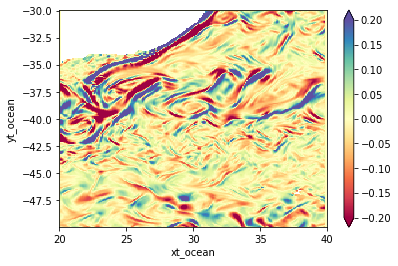

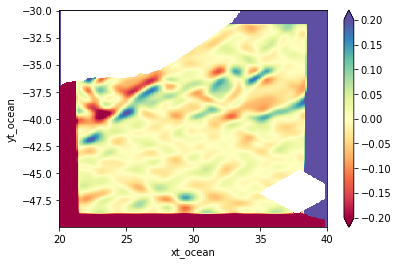

In [31]:
plt.figure()
vorticity.plot(**plt_args)
plt.figure()
filtered_vorticity.plot(**plt_args)
plt.show()

Plot of dxt over the map

In [ ]:
plt.figure()
grid_data['dxu'].plot(cmap='Spectral')#%%


Filter the velocities

In [13]:
u_filtered = mom5_filterU.apply(data['usurf'], ['yu_ocean', 'xu_ocean'])
v_filtered = mom5_filterU.apply(data['vsurf'], ['yu_ocean', 'xu_ocean'])

Compute the vorticity of the filtered field

/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:96: RuntimeWarning: invalid value encountered in double_scalars
  filtered_field[i,j]= (0.5* (self.dyu[i,j]+self.dyu[i+1,j])*fx[i,j]-\
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:98: RuntimeWarning: invalid value encountered in double_scalars
  (0.5* (self.dxu[i,j]+self.dxu[i,j+1])*fy[i,j]-\
/home/arthur/python/NYU/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: overflow encountered in multiply
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/arthur/python/NYU/gcm-filters/gcm_filters/filter.py:161: RuntimeWarning: overflow encountered in add
  field_bar += (1 / s_l) * tendency  # Update filtered field
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:88: RuntimeWarning: invalid value encountered in float_scalars
  fx[i,j]=(field[i+1,j]-field[i,j])*2.0/(self.dxt[i+1,j]+self.dxt[i+1,j+1])
/home/arthur/python/NYU/gcm-filters/gcm_filters/kernels.py:92: RuntimeWarning: invalid value e

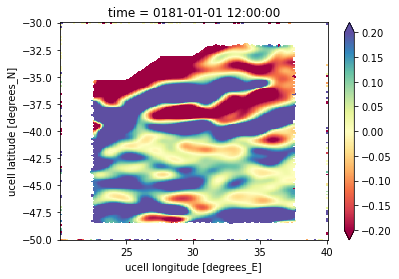

In [15]:
u_filtered.plot(**plt_args)